In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor

In [2]:
features_file = 'data/features.csv'
features_df = pd.read_csv(features_file)

stores_file = 'data/stores.csv'
stores_df = pd.read_csv(stores_file)

In [3]:
train_file = 'data/train.csv'
train_df = pd.read_csv(train_file)

# train_df = train_df.merge(stores_df, how='left')

train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df['Week'] = train_df.Date.apply(lambda x: x.weekofyear)
train_df['Year'] = train_df.Date.apply(lambda x: x.year)

#train_df.index = train_df['Date']
train_df = train_df.drop(['Date'], axis=1)

train_df.fillna(0, inplace=True)

# Set negative sales to 0
train_df.loc[train_df['Weekly_Sales'] < 0, 'Weekly_Sales'] = 0

# In competition evaluation, weights in WMAE are 5 if week is holiday, 1 otherwise
train_df['IsHoliday'].replace([False,True], [1,5], inplace = True)

train_df.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year
0,1,1,24924.50,1,5,2010
1,1,1,46039.49,5,6,2010
2,1,1,41595.55,1,7,2010
3,1,1,19403.54,1,8,2010
4,1,1,21827.90,1,9,2010


## Add columns for benchmark models : last week sales and last year sales 

In [16]:
train_df2 = train_df.copy()
#train_df2 = train_df2[train_df2['Store']<3]
  
# Get Last Week Sales and Last Year Sales by shifting values
# https://stackoverflow.com/questions/26280345/pandas-shift-down-values-by-one-row-within-a-group    
train_df2['Last_Week_Sales'] = train_df2.groupby(['Store','Dept'])['Weekly_Sales'].transform(lambda x:x.shift())
train_df2['Last_Year_Sales'] = train_df2.groupby(['Store','Dept','Week'])['Weekly_Sales'].transform(lambda x:x.shift())

# train_df2 = train_df2.dropna()
train_df2[(train_df2['Store']==1) & (train_df2['Dept']==1)].head()
#len(train_df2)

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year,Last_Week_Sales,Last_Year_Sales
0,1,1,24924.50,1,5,2010,NaN,NaN
1,1,1,46039.49,5,6,2010,24924.50,NaN
2,1,1,41595.55,1,7,2010,46039.49,NaN
3,1,1,19403.54,1,8,2010,41595.55,NaN
4,1,1,21827.90,1,9,2010,19403.54,NaN


## Dataframe with only weeks to predict

In [19]:
# we select the 36 last weeks of the data set
# its in 2012, from Week 8 to Week 43
predict_df = train_df2[(train_df2['Week'] >= 8) & (train_df2['Year'] == 2012)]

## WMAE / Store/dept / Last Week Sales

In [20]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]

for store in predict_df['Store'].unique():
    for dept in predict_df['Dept'].unique():
        
        # create a temporary data_df with data from our store and dept
        data_df = predict_df.copy()
        data_df = data_df[(data_df.Store == store)&(data_df.Dept == dept)]
        
        # We only take into account series with at least half of data
        if len(data_df['Weekly_Sales'].unique())>18:
            data_df['weighted_error']=data_df['IsHoliday']*abs(data_df['Weekly_Sales']-data_df['Last_Week_Sales'])
            sum_weights = data_df.IsHoliday.sum()
            sum_weighted_error = data_df.weighted_error.sum()
            
            # compute wmae for this store and dept
            wmae = (1/sum_weights) * sum_weighted_error
        
            if str(wmae) != 'nan':
                # We could print the WMAE for each store and dept by uncomment the following line
                # print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                
                # append sum_weights and sum_weighted error for this store to compute the global WMAE at the end
                total_sum_weights.append(sum_weights)
                total_sum_weighted_error.append(sum_weighted_error)
        
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series with Last Week Sales = {}'.format(str(global_wmae)))

Global Weighted mean absolute error (WMAE) for these predicted series with Last Week Sales = 1730.9347826124724


## WMAE / Store/dept / Last Year Sales

In [21]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]

for store in predict_df['Store'].unique():
    for dept in predict_df['Dept'].unique():
        
        # create a temporary data_df with data from our store and dept 
        data_df = predict_df.copy()
        data_df = data_df[(data_df.Store == store)&(data_df.Dept == dept)]
        
        # We only take into account series with at least half of data
        if len(data_df['Weekly_Sales'].unique())>18:
            data_df['weighted_error']=data_df['IsHoliday']*abs(data_df['Weekly_Sales']-data_df['Last_Year_Sales'])
            sum_weights = data_df.IsHoliday.sum()
            sum_weighted_error = data_df.weighted_error.sum()
            # compute wmae for this store and dept
            wmae = (1/sum_weights) * sum_weighted_error
        
            if str(wmae) != 'nan':
                # We could print the WMAE for each store and dept by uncomment the following line
                # print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                
                # append sum_weights and sum_weighted error for this store to compute the global WMAE at the end
                total_sum_weights.append(sum_weights)
                total_sum_weighted_error.append(sum_weighted_error)
        
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series with Last Week Sales = {}'.format(str(global_wmae)))

Global Weighted mean absolute error (WMAE) for these predicted series with Last Week Sales = 1838.5721100909461


## WMAE / Store/dept / Random Forest

In [24]:
train_df2.head()

,Store,Dept,Weekly_Sales,IsHoliday,Week,Year,Last_Week_Sales,Last_Year_Sales
0,1,1,24924.50,1,5,2010,NaN,NaN
1,1,1,46039.49,5,6,2010,24924.50,NaN
2,1,1,41595.55,1,7,2010,46039.49,NaN
3,1,1,19403.54,1,8,2010,41595.55,NaN
4,1,1,21827.90,1,9,2010,19403.54,NaN


In [25]:
train_df2 = train_df2.drop(['Last_Week_Sales','Last_Year_Sales'], axis=1)

Weighted mean absolute error (WMAE) for Store 1 Dept 1 = 3275.0028674999935


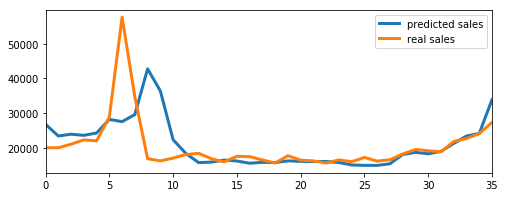

Weighted mean absolute error (WMAE) for Store 1 Dept 2 = 1382.09756


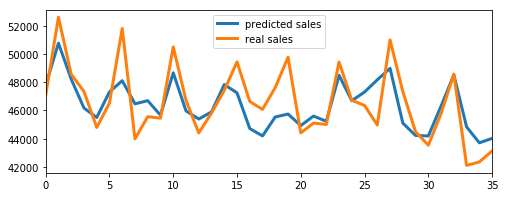

Weighted mean absolute error (WMAE) for Store 1 Dept 3 = 2634.845775


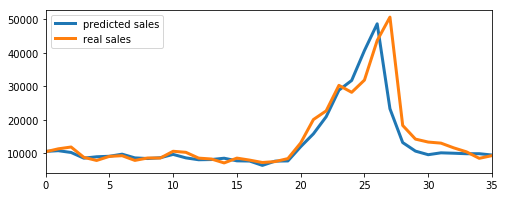

Weighted mean absolute error (WMAE) for Store 1 Dept 4 = 2091.6695275000125


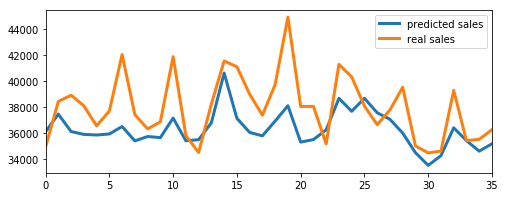

Weighted mean absolute error (WMAE) for Store 1 Dept 5 = 2715.80347


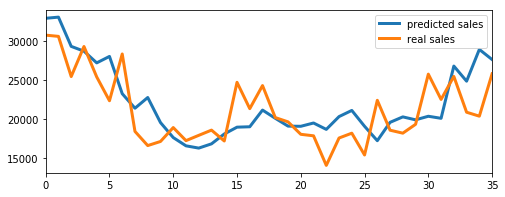

Weighted mean absolute error (WMAE) for Store 1 Dept 6 = 1292.7513349999997


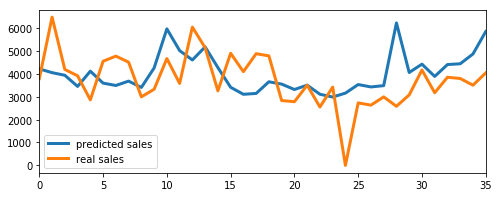

Weighted mean absolute error (WMAE) for Store 1 Dept 7 = 3025.726039999994


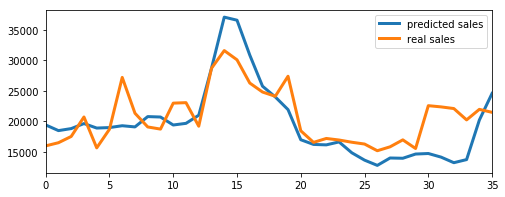

Weighted mean absolute error (WMAE) for Store 1 Dept 8 = 3904.847412499998


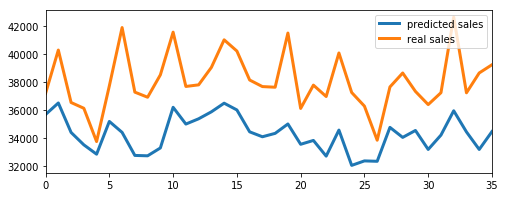

Weighted mean absolute error (WMAE) for Store 1 Dept 9 = 4736.611812499999


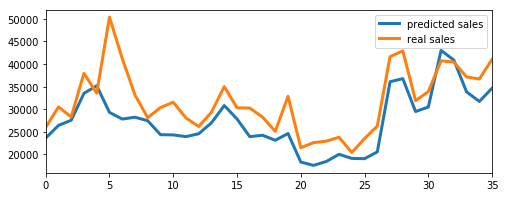

Weighted mean absolute error (WMAE) for Store 1 Dept 10 = 2697.1104325


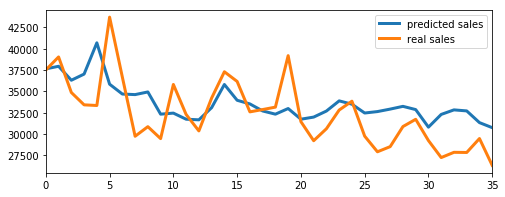

Weighted mean absolute error (WMAE) for Store 1 Dept 11 = 3302.1000975000047


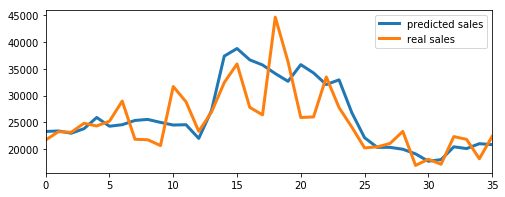

Weighted mean absolute error (WMAE) for Store 1 Dept 12 = 1197.0050050000007


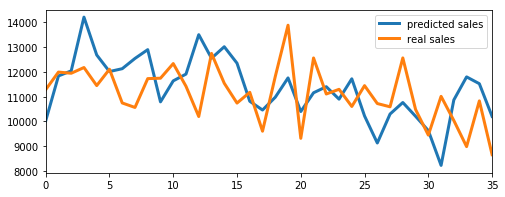

Weighted mean absolute error (WMAE) for Store 1 Dept 13 = 1981.403540000002


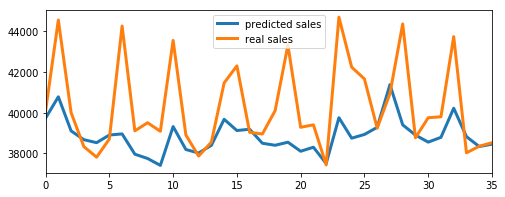

Weighted mean absolute error (WMAE) for Store 1 Dept 14 = 1285.1155274999992


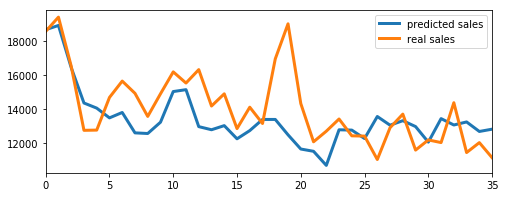

Weighted mean absolute error (WMAE) for Store 1 Dept 16 = 3396.1227324999963


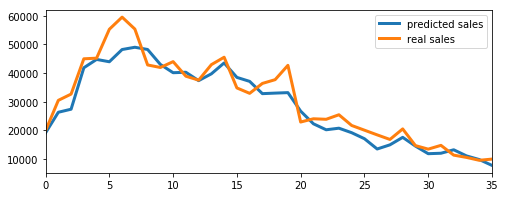

Weighted mean absolute error (WMAE) for Store 1 Dept 17 = 661.5393974999997


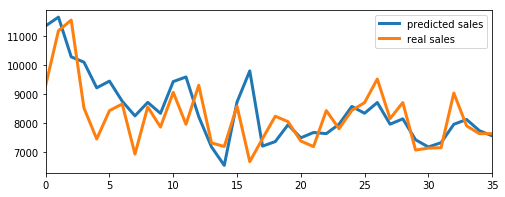

Weighted mean absolute error (WMAE) for Store 1 Dept 18 = 2454.9148451612905


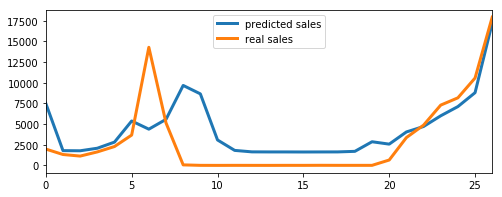

Weighted mean absolute error (WMAE) for Store 1 Dept 19 = 278.3752024999997


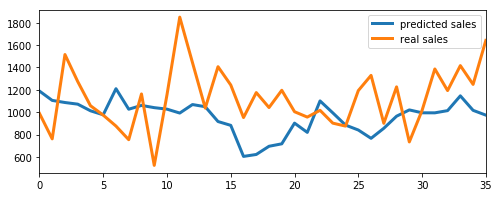

Global Weighted mean absolute error (WMAE) for these predicted series = 1555.322000844991


In [26]:
# Create some lists to compute WMAE for all of our series
total_sum_weights=[]
total_sum_weighted_error=[]
week = 8

# Create a train dataframe with data from 2010 to week 8 in 2012
train2010 = train_df2[train_df2['Year'] == 2010]
train2011 = train_df2[train_df2['Year'] == 2011]
train2012 = train_df2[(train_df['Year'] == 2012) & (train_df2['Week'] < week)]
train = train2010.append(train2011).append(train2012)

# Create a test dataframe with data from week 8 in 2012 (to get our wanted 36 weeks)
test = train_df2[(train_df2['Week'] >= week) & (train_df2['Year'] == 2012)]

for store in train_df2['Store'].unique():
    for dept in train_df2['Dept'].unique():
        
        # Select train and test dataframe for the wanted store and dept
        train_sd = train[(train.Store == store)&(train.Dept == dept)]
        test_sd = test[(test.Store == store)&(test.Dept == dept)]
        
        # Keep all data except Sales for xtrain and xtest
        xtrain = train_sd.drop(['Weekly_Sales'], axis=1)
        xtest = test_sd.drop(['Weekly_Sales'], axis=1)
        
        # Keep only Sales for ytrain and ytest
        ytrain = train_sd['Weekly_Sales'].values
        ytest = test_sd['Weekly_Sales'].values

        # Create a RandomForestRegressor model
        mdl = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
        if len(xtrain)>0:
            mdl.fit(xtrain, ytrain)
        
            if len(xtest)>0:
                p = mdl.predict(xtest)

                if len(p)>0:
                    xtest['weighted_error'] = xtest.IsHoliday * abs(ytest-p)
                    sum_weights = xtest.IsHoliday.sum()
                    sum_weighted_error = xtest.weighted_error.sum()
                    wmae = (1/sum_weights) * sum_weighted_error

                    if str(wmae) != 'nan':
                        if (store == 1) & (dept<20):
                            print('Weighted mean absolute error (WMAE) for Store {} Dept {} = {}'.format(str(store),str(dept),str(wmae)))
                            plot_df = pd.DataFrame()
                            plot_df['predicted_sales']=p
                            plot_df['real_sales']=ytest
                            plt.figure(figsize=(8,3))
                            plot_df['predicted_sales'].plot(label='predicted sales', lw=3)
                            plot_df['real_sales'].plot(label='real sales', lw=3)
                            plt.legend()
                            plt.show()

                        total_sum_weights.append(sum_weights)
                        total_sum_weighted_error.append(sum_weighted_error)
        
global_wmae = (1/sum(total_sum_weights)) * sum(total_sum_weighted_error)
print('Global Weighted mean absolute error (WMAE) for these predicted series = {}'.format(str(global_wmae)))